# Environment Setup and Configuration

In [ ]:
#Import, Parameters
import cv2
import numpy as np
import os, random, glob
from collections import defaultdict
from typing import List, Tuple
from tqdm import tqdm
import warnings

#Scikit-learn & Skimage
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC
from skimage.feature import hog

warnings.filterwarnings('ignore')
print("Libraries imported.")

# 1. Configuration
DATA_DIR = '../data'
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train', 'images')
TRAIN_LBL_DIR = os.path.join(DATA_DIR, 'train', 'labels')
VAL_IMG_DIR   = os.path.join(DATA_DIR, 'valid', 'images')
VAL_LBL_DIR   = os.path.join(DATA_DIR, 'valid', 'labels')
TEST_IMG_DIR   = os.path.join(DATA_DIR, 'test', 'images')
TEST_LBL_DIR   = os.path.join(DATA_DIR, 'test', 'labels')

CLASS_NAMES = [
    "Ants","Bees","Beetles","Caterpillars","Earthworms","Earwigs",
    "Grasshoppers","Moths","Slugs","Snails","Wasps","Weevils"
]

#Classifier Config
CLF_CONFIG = {
    'K_VOCAB_SIZE': 800,
    'SIFT_STEP': 16,
    'HOG_CELL': 64, 'HOG_BLOCK': 128, 'HOG_STRIDE': 64,
    'COLOR_BINS': 16,
    'W_BOVW': 1.0, 'W_HOG': 0.5, 'W_COLOR': 1.0,
    'C': 2.0, 'KERNEL': 'rbf', 'GAMMA': 'scale',
    'STD_SIZE': (320, 320)
}

#Detector Config
DET_SCORE_THRESH  = 0.5
DET_NMS_IOU_THR   = 0.3
PATCH_SIZE         = (128, 128)
HOG_ORIENTATIONS   = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
HOG_BLOCK_NORM     = 'L2-Hys'
HOG_TRANSFORM_SQRT = True
SVM_C            = 1.0
SVM_CLASS_WEIGHT = "balanced"
SVM_MAX_ITER     = 5000
SVM_RANDOM_STATE = 0
BACKGROUND_LABEL = 0
INSECT_LABEL     = 1

#Preprocessing Config
BORDER_PX      = 13
COLOR_SPACE    = "LAB"
COLOR_WEIGHT   = 1.6
EDGE_WEIGHT    = 2.75
GAUSS_KSIZE    = 5
CC_CONNECT     = 8
AREA_MIN_RATIO = 0.03
AREA_MAX_RATIO = 0.45
OTSU_BIAS      = 0.00

#Sampling Config
TRAIN_MAX_IMAGES      = 11000
VAL_MAX_IMAGES        = None
MAX_POS_PER_IMG       = 50
NEG_POS_RATIO         = 2.0
NEG_IOU_THR           = 0.1
BG_MAX_ATTEMPTS_FACTOR = 50

#Global Objects
sift = cv2.SIFT_create()


Libraries imported.


# Utilities

In [3]:
# 2. Utilities
def list_images(img_dir: str):
    exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.JPG", "*.JPEG", "*.PNG", "*.BMP")
    img_paths = []
    for ext in exts:
        img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
    img_paths = sorted(img_paths)
    return img_paths

def read_yolo_boxes(label_path: str, img_w: int, img_h: int):
    boxes, labels = [], []
    if not os.path.exists(label_path): return boxes, labels
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5: continue
            cls = int(float(parts[0]))
            xc, yc, w, h = map(float, parts[1:5])
            bw, bh = w * img_w, h * img_h
            x, y = (xc - w/2.0) * img_w, (yc - h/2.0) * img_h
            x, y = int(np.clip(x, 0, img_w - 1)), int(np.clip(y, 0, img_h - 1))
            bw, bh = int(np.clip(bw, 1, img_w - x)), int(np.clip(bh, 1, img_h - y))
            boxes.append((x, y, bw, bh))
            labels.append(cls)
    return boxes, labels

def iou_xywh(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    ax1, ay1, ax2, ay2 = x1, y1, x1 + w1 - 1, y1 + h1 - 1
    bx1, by1, bx2, by2 = x2, y2, x2 + w2 - 1, y2 + h2 - 1
    iw = max(0, min(ax2, bx2) - max(ax1, bx1) + 1)
    ih = max(0, min(ay2, by2) - max(ay1, by1) + 1)
    inter = iw * ih
    if inter <= 0: return 0.0
    area_a = w1 * h1
    area_b = w2 * h2
    return inter / float(area_a + area_b - inter + 1e-9)

def nms_xywh(boxes, scores, iou_thr=DET_NMS_IOU_THR):
    if len(boxes) == 0: return [], []
    boxes = np.array(boxes, dtype=np.float32)
    scores = np.array(scores, dtype=np.float32)
    order = scores.argsort()[::-1]
    keep_indices = []
    while len(order) > 0:
        i = order[0]
        keep_indices.append(int(i))
        if len(order) == 1: break
        rest = order[1:]
        i_box = boxes[i]
        ious = []
        for j in rest:
            j_box = boxes[j]
            ious.append(iou_xywh(tuple(i_box), tuple(j_box)))
        ious = np.array(ious, dtype=np.float32)
        remaining = rest[ious <= iou_thr]
        order = remaining
    final_boxes = [tuple(boxes[i].astype(int)) for i in keep_indices]
    final_scores = [float(scores[i]) for i in keep_indices]
    return final_boxes, final_scores


# Classification Module

In [ ]:
# 3. Classification Module (12 Classes)

#Extract HOG descriptor for an input image
def clf_get_hog(img, cfg):
    win_size = cfg['STD_SIZE']
    block_size = (cfg['HOG_BLOCK'], cfg['HOG_BLOCK'])
    block_stride = (cfg['HOG_STRIDE'], cfg['HOG_STRIDE'])
    cell_size = (cfg['HOG_CELL'], cfg['HOG_CELL'])
    if img.shape[:2] != win_size[::-1]:
        img = cv2.resize(img, win_size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_desc = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, 9)
    return hog_desc.compute(gray).flatten()

#Compute HSV colour histogram:
def clf_get_color(img, bins):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    chans = cv2.split(hsv)
    hists = [cv2.calcHist([c],[0],None,[bins],[0,256]) for c in chans]
    for h in hists: cv2.normalize(h, h)
    return np.hstack([h.flatten() for h in hists])

#Extract Dense SIFT
def clf_get_dense_sift(imgs, step):
    descs = []
    for img in imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kps = [cv2.KeyPoint(x, y, step) for y in range(0, gray.shape[0], step) for x in range(0, gray.shape[1], step)]
        _, d = sift.compute(gray, kps)
        descs.append(d)
    return descs

#Build final feature vector
def clf_create_features(imgs, vocab, cfg):
    descs = clf_get_dense_sift(imgs, cfg['SIFT_STEP'])
    k = vocab.n_clusters
    bovw_feats = np.zeros((len(imgs), k), np.float32)
    for i, d in enumerate(descs):
        if d is not None:
            words = vocab.predict(d)
            hist, _ = np.histogram(words, bins=np.arange(k+1))
            if hist.sum() > 0: hist = hist / np.linalg.norm(hist)
            bovw_feats[i] = hist
    other_feats = []
    for im in imgs:
        h = clf_get_hog(im, cfg)
        c = clf_get_color(im, cfg['COLOR_BINS'])
        other_feats.append(np.hstack((cfg['W_HOG']*h, cfg['W_COLOR']*c)))
    return np.hstack((cfg['W_BOVW'] * bovw_feats, np.array(other_feats)))

#Load training data and train the classifier
def load_classifier_data_and_train(max_images=3000):
    print("\nClassifier Loading Training Data")
    files = os.listdir(TRAIN_LBL_DIR)
    random.shuffle(files)
    if max_images: files = files[:max_images]
    
    train_imgs, train_lbls = [], []
    for f in tqdm(files, desc="Loading Train Crops"):
        if not f.endswith('.txt'): continue
        img_path = os.path.join(TRAIN_IMG_DIR, os.path.splitext(f)[0] + '.jpg')
        if not os.path.exists(img_path): continue
        img = cv2.imread(img_path)
        if img is None: continue
        h, w, _ = img.shape
        with open(os.path.join(TRAIN_LBL_DIR, f)) as lf:
            for line in lf:
                try:
                    cid, x, y, wn, hn = map(float, line.split())
                    x1, y1 = int((x-wn/2)*w), int((y-hn/2)*h)
                    x2, y2 = int((x+wn/2)*w), int((y+hn/2)*h)
                    crop = img[max(0,y1):min(h,y2), max(0,x1):min(w,x2)]
                    if crop.size > 0:
                        train_imgs.append(cv2.resize(crop, CLF_CONFIG['STD_SIZE']))
                        train_lbls.append(int(cid))
                except: continue
    print(f"Loaded {len(train_imgs)} training crops.")
    
    print("Training BoVW Voca")
    vocab = MiniBatchKMeans(n_clusters=CLF_CONFIG['K_VOCAB_SIZE'], batch_size=512, n_init=3, max_iter=100)
    sample_imgs = train_imgs[:1000] if len(train_imgs) > 1000 else train_imgs
    descs = clf_get_dense_sift(sample_imgs, CLF_CONFIG['SIFT_STEP'])
    flat_descs = np.vstack([d for d in descs if d is not None])
    vocab.fit(flat_descs)
    
    print("Training SVC")
    X_train = clf_create_features(train_imgs, vocab, CLF_CONFIG)
    y_train = np.array(train_lbls)
    clf_model = make_pipeline(
        StandardScaler(),
        SVC(C=CLF_CONFIG['C'], kernel=CLF_CONFIG['KERNEL'], class_weight='balanced', probability=True)
    )
    clf_model.fit(X_train, y_train)
    return clf_model, vocab



# Detector module

In [5]:
# 4. Detector Module

#Feature Extraction
def crop_resize_gray(bgr: np.ndarray, box: Tuple[int, int, int, int], size: Tuple[int, int] = PATCH_SIZE):
    x, y, w, h = box
    H, W = bgr.shape[:2]
    x0 = max(0, x); y0 = max(0, y)
    x1 = min(W, x + w); y1 = min(H, y + h)
    if x0 >= x1 or y0 >= y1: return None
    crop = bgr[y0:y1, x0:x1]
    if crop.size == 0: return None
    crop_resized = cv2.resize(crop, (size[1], size[0]), interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(crop_resized, cv2.COLOR_BGR2GRAY)
    return gray

def extract_hog_feature(gray: np.ndarray):
    feat = hog(
        gray,
        orientations=HOG_ORIENTATIONS,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        block_norm=HOG_BLOCK_NORM,
        transform_sqrt=HOG_TRANSFORM_SQRT,
        feature_vector=True
    )
    return feat.astype(np.float32)

#Training Dataset ready
def sample_background_boxes(H, W, gt_boxes, num_neg, neg_iou_thr=NEG_IOU_THR, max_attempts_factor=BG_MAX_ATTEMPTS_FACTOR):
    boxes = []
    if num_neg <= 0: return boxes
    max_attempts = max_attempts_factor * num_neg
    attempts = 0
    while len(boxes) < num_neg and attempts < max_attempts:
        attempts += 1
        min_size = max(16, min(H, W) // 10)
        max_size = max(min_size + 1, min(H, W) // 2)
        bw = np.random.randint(min_size, max_size)
        bh = np.random.randint(min_size, max_size)
        if bw <= 0 or bh <= 0: continue
        x = np.random.randint(0, max(1, W - bw + 1))
        y = np.random.randint(0, max(1, H - bh + 1))
        box = (x, y, bw, bh)
        ious = [iou_xywh(box, g) for g in gt_boxes]
        if len(ious) > 0 and max(ious) > neg_iou_thr: continue
        boxes.append(box)
    return boxes

def build_binary_dataset_for_split(img_dir, lbl_dir, split_name="train", max_images=None, max_pos_per_img=MAX_POS_PER_IMG, neg_pos_ratio=NEG_POS_RATIO, neg_iou_thr=NEG_IOU_THR):
    img_paths = list_images(img_dir)
    if max_images is not None: img_paths = img_paths[:max_images]
    if len(img_paths) == 0: raise RuntimeError(f"No images found in {img_dir}")
    X_list, y_list = [], []
    total_pos, total_neg = 0, 0
    for img_path in tqdm(img_paths, desc=f"Build binary HOG dataset @ {split_name}"):
        bgr = cv2.imread(img_path)
        if bgr is None: continue
        H, W = bgr.shape[:2]
        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(lbl_dir, base + ".txt")
        gt_boxes, gt_labels = read_yolo_boxes(label_path, W, H)
        # Positive
        pos_boxes = gt_boxes
        if max_pos_per_img is not None and len(pos_boxes) > max_pos_per_img: pos_boxes = pos_boxes[:max_pos_per_img]
        for box in pos_boxes:
            gray = crop_resize_gray(bgr, box)
            if gray is None: continue
            feat = extract_hog_feature(gray)
            X_list.append(feat)
            y_list.append(INSECT_LABEL)
            total_pos += 1
        # Negative
        if neg_pos_ratio > 0:
            pos_count_for_neg = len(pos_boxes) if len(pos_boxes) > 0 else (max_pos_per_img or 10)
            num_neg_desired = int(pos_count_for_neg * neg_pos_ratio)
            bg_boxes = sample_background_boxes(H, W, gt_boxes, num_neg=num_neg_desired, neg_iou_thr=neg_iou_thr)
            for box in bg_boxes:
                gray_bg = crop_resize_gray(bgr, box)
                if gray_bg is None: continue
                feat_bg = extract_hog_feature(gray_bg)
                X_list.append(feat_bg)
                y_list.append(BACKGROUND_LABEL)
                total_neg += 1
    if len(X_list) == 0: raise RuntimeError(f"No samples collected from {img_dir}.")
    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int32)
    print(f"[INFO] {split_name} split: total sample = {len(y)}")
    print(f"[INFO]   - Positive(Insect=1): {total_pos}")
    print(f"[INFO]   - Negative(Background=0): {total_neg}")
    return X, y

#Image Segmenatation
def _to_colorspace(bgr, mode="LAB"):
    mode = mode.upper()
    if mode == "LAB": return cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    elif mode == "HSV": return cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    else: raise ValueError("COLOR_SPACE must be 'LAB' or 'HSV'.")

def _border_stats(colimg, border_px):
    H, W = colimg.shape[:2]
    m = np.zeros((H, W), np.uint8)
    m[:border_px,:] = 1; m[-border_px:,:] = 1; m[:,:border_px] = 1; m[:,-border_px:] = 1
    samples = colimg[m>0].reshape(-1, colimg.shape[2])
    mu  = np.median(samples, axis=0).astype(np.float32)
    cov = np.cov(samples.T).astype(np.float32) if len(samples)>=10 else np.eye(colimg.shape[2], dtype=np.float32)
    return mu, cov

def _mahalanobis(X, mu, cov):
    C = cov.shape[0]
    inv = np.linalg.inv(cov + 1e-6*np.eye(C, dtype=np.float32))
    d = (X - mu).astype(np.float32)
    return np.sqrt(np.einsum('...i,ij,...j->...', d, inv, d)).astype(np.float32)

def _grad_mag(gray):
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(gx, gy)
    mag = mag / (mag.max() + 1e-6)
    return mag.astype(np.float32)

def _norm01(x):
    x = x.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    return np.zeros_like(x) if mx-mn < 1e-6 else (x-mn)/(mx-mn)

def make_fg_mask_simple(bgr):
    H, W = bgr.shape[:2]
    blur = cv2.GaussianBlur(bgr, (GAUSS_KSIZE, GAUSS_KSIZE), 0)
    col = _to_colorspace(blur, COLOR_SPACE)
    mu, cov = _border_stats(col, BORDER_PX)
    dist = _mahalanobis(col.reshape(-1, col.shape[2]), mu, cov).reshape(H, W)
    color_score = _norm01(dist)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    edge_score = _grad_mag(gray)
    fused = COLOR_WEIGHT*color_score + EDGE_WEIGHT*edge_score
    fused = _norm01(fused)
    if OTSU_BIAS != 0.0: fused = np.clip(fused - OTSU_BIAS, 0, 1)
    fused_u8 = (fused*255).astype(np.uint8)
    _, mask = cv2.threshold(fused_u8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=int(CC_CONNECT))
    out = np.zeros_like(mask)
    img_area = H*W
    for i in range(1, num):
        x,y,w,h,area = stats[i]
        if area < AREA_MIN_RATIO*img_area or area > AREA_MAX_RATIO*img_area: continue
        out[labels==i] = 255
    return out

#Regoin Proposal Logic
def propose_boxes_from_mask(mask, min_area_ratio=0.001, max_area_ratio=0.90, pad=4, connectivity=8, merge=True, merge_iou=0.30):
    if mask is None or mask.size == 0: return []
    if mask.dtype != np.uint8: binm = (mask > 0).astype(np.uint8)
    else: binm = (mask > 0).astype(np.uint8)
    H, W = binm.shape[:2]
    img_area = H * W
    if img_area == 0: return []
    num, labels, stats, _ = cv2.connectedComponentsWithStats(binm, connectivity=int(connectivity))
    boxes = []
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        if area < min_area_ratio * img_area or area > max_area_ratio * img_area: continue
        x0 = max(0, x - pad); y0 = max(0, y - pad)
        x1 = min(W - 1, x + w + pad - 1); y1 = min(H - 1, y + h + pad - 1)
        boxes.append((int(x0), int(y0), int(max(1, x1 - x0 + 1)), int(max(1, y1 - y0 + 1))))
    if not merge or len(boxes) <= 1:
        boxes.sort(key=lambda b: b[2]*b[3], reverse=True)
        return boxes
    def _xywh_to_xyxy(b): return (b[0], b[1], b[0] + b[2] - 1, b[1] + b[3] - 1)
    def _xyxy_to_xywh(b): return (b[0], b[1], b[2] - b[0] + 1, b[3] - b[1] + 1)
    def _iou(a, b):
        iw = max(0, min(a[2], b[2]) - max(a[0], b[0]) + 1)
        ih = max(0, min(a[3], b[3]) - max(a[1], b[1]) + 1)
        inter = iw * ih
        if inter <= 0: return 0.0
        area_a = (a[2]-a[0]+1)*(a[3]-a[1]+1)
        area_b = (b[2]-b[0]+1)*(b[3]-b[1]+1)
        return inter / float(area_a + area_b - inter + 1e-9)
    xyxy = [_xywh_to_xyxy(b) for b in boxes]
    changed = True
    while changed and len(xyxy) > 1:
        changed = False
        new_xyxy = []
        used = [False] * len(xyxy)
        for i in range(len(xyxy)):
            if used[i]: continue
            merged = xyxy[i]
            used[i] = True
            for j in range(i + 1, len(xyxy)):
                if used[j]: continue
                if _iou(merged, xyxy[j]) >= merge_iou:
                    x1 = min(merged[0], xyxy[j][0]); y1 = min(merged[1], xyxy[j][1])
                    x2 = max(merged[2], xyxy[j][2]); y2 = max(merged[3], xyxy[j][3])
                    merged = (x1, y1, x2, y2)
                    used[j] = True
                    changed = True
            new_xyxy.append(merged)
        xyxy = new_xyxy
    merged_boxes = [_xyxy_to_xywh(b) for b in xyxy]
    merged_boxes.sort(key=lambda b: b[2]*b[3], reverse=True)
    return merged_boxes

def get_candidate_boxes(bgr, use_preproc=True):
    H, W = bgr.shape[:2]
    all_boxes = []
    if use_preproc:
        fg_mask = make_fg_mask_simple(bgr)
        boxes_fg = propose_boxes_from_mask(fg_mask, min_area_ratio=0.001, max_area_ratio=0.9, pad=4, connectivity=8, merge=True, merge_iou=0.30)
        all_boxes.extend(boxes_fg)
    all_boxes = list({(x, y, w, h) for (x, y, w, h) in all_boxes})
    return all_boxes

#Score candidate boxes with SVM,and NMS
def compute_scores_for_boxes(bgr, boxes, scaler, svm):
    feats = []
    valid_boxes = []
    for box in boxes:
        gray = crop_resize_gray(bgr, box, size=PATCH_SIZE)
        if gray is None: continue
        feat = extract_hog_feature(gray)
        feats.append(feat)
        valid_boxes.append(box)
    if len(feats) == 0: return [], np.array([])
    X = np.vstack(feats).astype(np.float32)
    X_std = scaler.transform(X)
    scores = svm.decision_function(X_std)
    return valid_boxes, scores

def filter_boxes_by_score(boxes, scores, score_thr):
    if len(boxes) == 0 or scores.size == 0: return [], np.array([])
    keep_idx = np.where(scores >= score_thr)[0]
    if len(keep_idx) == 0: return [], np.array([])
    boxes_pos = [boxes[i] for i in keep_idx]
    scores_pos = scores[keep_idx]
    return boxes_pos, scores_pos

def detect_in_image(bgr, scaler, svm, use_preproc=True):
    all_boxes = get_candidate_boxes(bgr, use_preproc=use_preproc)
    if len(all_boxes) == 0: return [], np.array([])
    valid_boxes, scores = compute_scores_for_boxes(bgr, all_boxes, scaler, svm)
    if len(valid_boxes) == 0: return [], np.array([])
    boxes_pos, scores_pos = filter_boxes_by_score(valid_boxes, scores, DET_SCORE_THRESH)
    if len(boxes_pos) == 0: return [], np.array([])
    final_boxes, final_scores = nms_xywh(boxes_pos, scores_pos, iou_thr=DET_NMS_IOU_THR)
    return final_boxes, final_scores


# Execution

In [ ]:
# MAIN EXECUTION (Train)
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    
    # 1. Train Classifier (12 Classes)
    print("\n Training Multi Class Classifier")
    clf_model, vocab = load_classifier_data_and_train(max_images=TRAIN_MAX_IMAGES)
    
    # 2. Train Detector (Binary)
    print("\nTraining Binary Detector")
    # 2-1. Train set
    X_train_det, y_train_det = build_binary_dataset_for_split(
        TRAIN_IMG_DIR, TRAIN_LBL_DIR, split_name="train",
        max_images=TRAIN_MAX_IMAGES, max_pos_per_img=MAX_POS_PER_IMG,
        neg_pos_ratio=NEG_POS_RATIO, neg_iou_thr=NEG_IOU_THR
    )
    # 2-2. Valid set
    X_val_det, y_val_det = build_binary_dataset_for_split(
        VAL_IMG_DIR, VAL_LBL_DIR, split_name="valid",
        max_images=VAL_MAX_IMAGES, max_pos_per_img=MAX_POS_PER_IMG,
        neg_pos_ratio=NEG_POS_RATIO, neg_iou_thr=NEG_IOU_THR
    )
    # 2-3. Scaler & SVM
    print("\nTraining Detector SVM")
    det_scaler = StandardScaler()
    X_train_std = det_scaler.fit_transform(X_train_det)
    det_model = LinearSVC(
        C=SVM_C, class_weight=SVM_CLASS_WEIGHT,
        max_iter=SVM_MAX_ITER, random_state=SVM_RANDOM_STATE
    )
    det_model.fit(X_train_std, y_train_det)
    

# Evaluation 

In [ ]:
import os
import cv2
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Compute mAP@IoU
def compute_map(all_preds, all_gts, num_classes, iou_thr=0.5):
    aps = []

    for cid in range(num_classes):
        preds_c = [p for p in all_preds if p['class_id'] == cid]
        gts_c   = [g for g in all_gts   if g['class_id'] == cid]

        if len(gts_c) == 0:
            continue

        preds_c = sorted(preds_c, key=lambda x: x['score'], reverse=True)

        tp = np.zeros(len(preds_c), dtype=np.float32)
        fp = np.zeros(len(preds_c), dtype=np.float32)

        gt_used = [False] * len(gts_c)

        for i, pred in enumerate(preds_c):
            best_iou = 0.0
            best_gt_idx = -1
            for j, gt in enumerate(gts_c):
                if pred['img_id'] != gt['img_id']:
                    continue
                iou = iou_xywh(pred['box'], gt['box'])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j

            if best_iou >= iou_thr and best_gt_idx >= 0 and not gt_used[best_gt_idx]:
                tp[i] = 1.0
                gt_used[best_gt_idx] = True
            else:
                fp[i] = 1.0

        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)

        recalls = tp_cum / (len(gts_c) + 1e-9)
        precisions = tp_cum / (tp_cum + fp_cum + 1e-9)

        if len(precisions) == 0:
            aps.append(0.0)
            continue

        mpre = np.concatenate(([0.0], precisions, [0.0]))
        mrec = np.concatenate(([0.0], recalls,    [1.0]))

        for k in range(len(mpre) - 2, -1, -1):
            mpre[k] = max(mpre[k], mpre[k + 1])

        idx = np.where(mrec[1:] != mrec[:-1])[0]
        ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
        aps.append(ap)

    if len(aps) == 0:
        return 0.0
    return float(np.mean(aps))

#Full-system evaluation: runs detection -> classification -> metric calculation
def evaluate_full_system(
    clf_model,
    vocab,
    det_model,
    det_scaler,
    img_dir,
    lbl_dir,
    max_images=None,
    iou_thr=0.5
):
    img_paths = list_images(img_dir)
    if max_images is not None:
        img_paths = img_paths[:max_images]

    class_stats = defaultdict(lambda: {'TP': 0, 'FP': 0, 'n_gt': 0})

    all_preds = []  
    all_gts   = []  

    detection_records = [] 

    for img_path in tqdm(img_paths, desc="Eval Full System"):
        img_id = os.path.basename(img_path)
        bgr = cv2.imread(img_path)
        if bgr is None:
            continue
        H, W = bgr.shape[:2]

        label_path = os.path.join(lbl_dir, os.path.splitext(img_id)[0] + ".txt")
        gt_boxes, gt_labels = read_yolo_boxes(label_path, W, H)

        image_gt_by_class = defaultdict(list)
        for gb, gl in zip(gt_boxes, gt_labels):
            all_gts.append({'img_id': img_id, 'box': gb, 'class_id': gl})
            image_gt_by_class[gl].append(gb)
            class_stats[gl]['n_gt'] += 1

        # Detection
        final_boxes, final_scores = detect_in_image(
            bgr,
            det_scaler,
            det_model,
            use_preproc=True
        )

        if len(final_boxes) == 0:
            continue

        rois = []
        for box in final_boxes:
            x, y, w, h = box
            crop = bgr[y:y+h, x:x+w]
            if crop.size > 0:
                roi = cv2.resize(crop, CLF_CONFIG['STD_SIZE'])
            else:
                roi = np.zeros((CLF_CONFIG['STD_SIZE'][0],
                                CLF_CONFIG['STD_SIZE'][1], 3), dtype=np.uint8)
            rois.append(roi)

        X_clf = clf_create_features(rois, vocab, CLF_CONFIG)
        cls_probs = clf_model.predict_proba(X_clf)
        pred_classes = np.argmax(cls_probs, axis=1)
        pred_scores  = np.max(cls_probs, axis=1)

        for cid in range(len(CLASS_NAMES)):
            preds_c = []
            gts_c   = image_gt_by_class[cid]

            for box, pcls, pscore in zip(final_boxes, pred_classes, pred_scores):
                if pcls == cid:
                    preds_c.append((box, pscore))

            if len(gts_c) == 0 and len(preds_c) == 0:
                continue

            used_gt = [False] * len(gts_c)

            preds_c_sorted = sorted(preds_c, key=lambda x: x[1], reverse=True)

            for (pb, pscore) in preds_c_sorted:
                best_iou = 0.0
                best_gt_idx = -1
                for gi, gb in enumerate(gts_c):
                    if used_gt[gi]:
                        continue
                    iou = iou_xywh(pb, gb)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gi

                if best_iou >= iou_thr and best_gt_idx >= 0:
                    class_stats[cid]['TP'] += 1
                    used_gt[best_gt_idx] = True
                else:
                    class_stats[cid]['FP'] += 1

        for box, pcls, pscore in zip(final_boxes, pred_classes, pred_scores):
            all_preds.append({
                'img_id': img_id,
                'box': box,
                'class_id': int(pcls),
                'score': float(pscore)
            })

            best_iou = 0.0
            best_gt_cls = None
            for gb, gl in zip(gt_boxes, gt_labels):
                iou = iou_xywh(box, gb)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_cls = gl

            is_match = best_iou >= iou_thr and best_gt_cls is not None
            is_correct_class = (is_match and (best_gt_cls == pcls))

            detection_records.append({
                'img_path': img_path,
                'img_id': img_id,
                'box': box,
                'pred_cls': int(pcls),
                'pred_score': float(pscore),
                'best_iou': float(best_iou),
                'gt_cls': int(best_gt_cls) if best_gt_cls is not None else None,
                'is_match': bool(is_match),
                'is_correct_class': bool(is_correct_class)
            })

    print("\n" + "-"*80)
    print(f"{'Class':<15} | {'Prec.':<8} | {'Recall':<8} | {'F1':<8} | {'TP':<5} | {'FP':<5} | {'GT':<5}")
    print("-"*80)

    macro_prec = 0.0
    macro_rec  = 0.0
    macro_f1   = 0.0
    valid_classes = 0

    for cid in range(len(CLASS_NAMES)):
        stats = class_stats[cid]
        tp = stats['TP']
        fp = stats['FP']
        gt = stats['n_gt']
        fn = gt - tp

        prec = tp / (tp + fp + 1e-9)
        rec  = tp / (tp + fn + 1e-9)
        f1   = 2 * prec * rec / (prec + rec + 1e-9)

        if gt > 0:
            macro_prec += prec
            macro_rec  += rec
            macro_f1   += f1
            valid_classes += 1

        print(f"{CLASS_NAMES[cid]:<15} | {prec:.4f}   | {rec:.4f}   | {f1:.4f}   | {tp:<5} | {fp:<5} | {gt:<5}")

    print("-"*80)
    if valid_classes > 0:
        print(f"{'Macro Avg':<15} | {macro_prec/valid_classes:.4f}   | {macro_rec/valid_classes:.4f}   | {macro_f1/valid_classes:.4f}   | -     | -     | -")

    mAP = compute_map(all_preds, all_gts, num_classes=len(CLASS_NAMES), iou_thr=iou_thr)
    print(f"\n>>> Final mAP@{iou_thr:.2f}: {mAP:.4f}")

    return {
        'class_stats': class_stats,
        'mAP': mAP,
        'detection_records': detection_records
    }

def visualize_detections(
    detection_records,
    num_good=3,
    num_bad=3,
    iou_thr=0.5,
    score_thr=0.0,
    random_seed=0
):
    import random
    random.seed(random_seed)
    good = [
        rec for rec in detection_records
        if rec['pred_score'] >= score_thr
        and rec['is_correct_class']
        and rec['best_iou'] >= iou_thr
    ]

    bad = [
        rec for rec in detection_records
        if rec['pred_score'] >= score_thr
        and (not rec['is_correct_class'])
    ]

    print(f"[INFO] Available good(TP) samples: {len(good)}")
    print(f"[INFO] Available bad(FP/misclass) samples: {len(bad)}")

    good_samples = random.sample(good, min(num_good, len(good))) if len(good) > 0 else []
    bad_samples  = random.sample(bad,  min(num_bad,  len(bad)))  if len(bad)  > 0 else []

    def _show_samples(samples, title_prefix, box_color, max_cols=3):
        if not samples:
            print(f"[WARN] No samples to show for {title_prefix}")
            return

        n = len(samples)
        ncols = min(max_cols, n)
        nrows = int(np.ceil(n / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
        if nrows == 1 and ncols == 1:
            axes = [[axes]]
        elif nrows == 1:
            axes = [axes]

        for idx, rec in enumerate(samples):
            r = idx // ncols
            c = idx % ncols
            ax = axes[r][c]

            img = cv2.imread(rec['img_path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            x, y, w, h = rec['box']
            rect = patches.Rectangle(
                (x, y), w, h,
                linewidth=2, edgecolor=box_color, facecolor='none'
            )

            ax.imshow(img)
            ax.add_patch(rect)

            pred_name = CLASS_NAMES[rec['pred_cls']]
            if rec['gt_cls'] is not None:
                gt_name = CLASS_NAMES[rec['gt_cls']]
            else:
                gt_name = "None"

            ax.set_title(
                f"{title_prefix}\n"
                f"Pred: {pred_name} ({rec['pred_score']:.2f})\n"
                f"GT: {gt_name}, IoU={rec['best_iou']:.2f}",
                fontsize=9
            )
            ax.axis('off')

        for idx in range(n, nrows*ncols):
            r = idx // ncols
            c = idx % ncols
            axes[r][c].axis('off')

        plt.tight_layout()
        plt.show()
    _show_samples(good_samples, title_prefix="True Positive", box_color='g')

    _show_samples(bad_samples, title_prefix="False Positive / Misclassified", box_color='r')


Eval Full System: 100%|██████████| 546/546 [00:28<00:00, 19.13it/s]



--------------------------------------------------------------------------------
Class           | Prec.    | Recall   | F1       | TP    | FP    | GT   
--------------------------------------------------------------------------------
Ants            | 0.4286   | 0.1724   | 0.2459   | 15    | 20    | 87   
Bees            | 0.3462   | 0.2045   | 0.2571   | 9     | 17    | 44   
Beetles         | 0.0000   | 0.0000   | 0.0000   | 0     | 14    | 44   
Caterpillars    | 0.1765   | 0.0968   | 0.1250   | 9     | 42    | 93   
Earthworms      | 0.0952   | 0.0500   | 0.0656   | 2     | 19    | 40   
Earwigs         | 0.3056   | 0.1507   | 0.2018   | 11    | 25    | 73   
Grasshoppers    | 0.2200   | 0.2000   | 0.2095   | 11    | 39    | 55   
Moths           | 0.6429   | 0.5745   | 0.6067   | 27    | 15    | 47   
Slugs           | 0.1333   | 0.0392   | 0.0606   | 2     | 13    | 51   
Snails          | 0.5333   | 0.3200   | 0.4000   | 16    | 14    | 50   
Wasps           | 0.5484   | 0.361

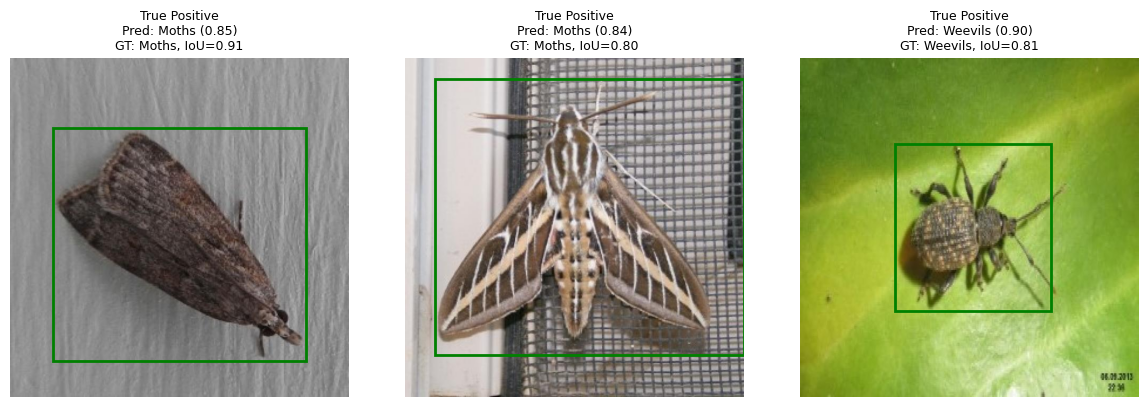

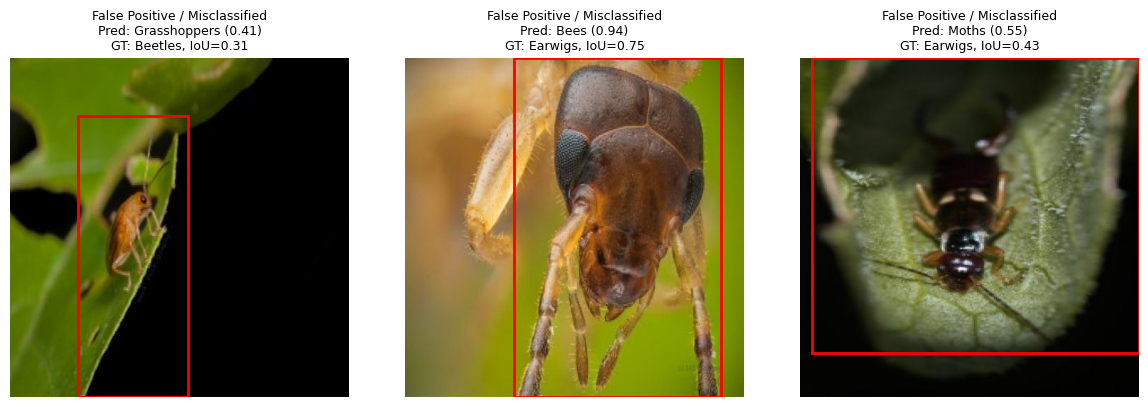

In [28]:
results = evaluate_full_system(
    clf_model=clf_model,
    vocab=vocab,
    det_model=det_model,
    det_scaler=det_scaler,
    img_dir=TEST_IMG_DIR,
    lbl_dir=TEST_LBL_DIR,
    max_images=None,   
    iou_thr=0.5
)

detection_records = results['detection_records']

visualize_detections(
    detection_records,
    num_good=3,   
    num_bad=3,    
    iou_thr=0.5,
    score_thr=0.3,   
    random_seed=0
)